In [1]:
import json
import pandas as pd
from collections import defaultdict
import subprocess
from scipy import stats
from statsmodels.stats import multitest
import numpy as np
import pybedtools
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [2]:
import matplotlib
from pathlib import Path
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [3]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

# Get ChIP-seq signals at peak regions

In [4]:
s = "C1"
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]
gs = [f"{p}_{d}" for p, d in itertools.product(ps, ds)]

In [5]:
inputfile = f"{PROJECT_DIR_r}ENCODE/acc_target.json"
with open(inputfile, "r") as f:
	acc_target = json.load(f)

In [6]:
fb = " ".join([f"{PROJECT_DIR_r}ENCODE/{acc}.bed.gz" for acc in acc_target])
for g in gs:
	fa = f"{PROJECT_DIR_d}bed_plot/{s}_{g}.bed"
	outputfile = f"{PROJECT_DIR_o}temp/{s}_{g}_ChIP.bed"
	commands = " ".join(["bedtools intersect",
						 "-a", fa,
						 "-b", fb,
						 "-wao",
						 ">", outputfile
						])
	subprocess.run(commands, shell=True)

In [7]:
# Column 0-7: PRO-cap peak files
# Column 8: ChIP-seq file number from which the overlap came; the number (1-based) corresponds to the order in which the files were given on the command line
# Column 9-18: ChIP-seq files (ENCODE narrowPeak file format: https://genome.ucsc.edu/FAQ/FAQformat.html#format12)
# Column 19: the overlap length

inputfile = f"{PROJECT_DIR_o}temp/{s}_{g}_ChIP.bed"
df = pd.read_table(inputfile, header=None, low_memory=False)
df.head(2)

0       1       2       3       4       5  6  7   8     9       10  \
0  chr1  975962  976463  976227  976241  976240  .  +  12  chr1  976084   
1  chr1  975962  976463  976227  976241  976240  .  +  22  chr1  976105   

       11 12    13 14         15        16       17   18   19  
0  976384  .   661  .   28.16687  -1.00000  4.31149  150  300  
1  976297  .  1000  .  191.81867  -1.00000  3.96220   94  192

In [8]:
# Get signals at each element for each ChIP-seq file

values = {g: defaultdict(dict) for g in gs}
for g in gs:
    inputfile = f"{PROJECT_DIR_o}temp/{s}_{g}_ChIP.bed"
    df = pd.read_table(inputfile, header=None, low_memory=False)
    for _, row in df.iterrows():
        if int(row[19]) > 0:
            chrom, start, end = row[:3]
            acc = list(acc_target.keys())[int(row[8]) - 1]
            signalValue = float(row[15])
            values[g][(chrom, start, end)].setdefault(acc, []).append(signalValue)

# ChIP-seq signal enrichment

## Calculate enrichment

In [9]:
es = {}
for g in gs:
	b = pybedtools.BedTool(f"{PROJECT_DIR_d}bed_plot/{s}_{g}.bed")
	es[g] = [(i.fields[0], int(i.fields[1]), int(i.fields[2])) for i in b]

In [10]:
# For a given experiment:
# Overlapping peaks of a given target protein: keep the maximum value
# No overlaps: 0

values2 = {acc: defaultdict(list) for acc in acc_target}
for g in gs:
    for e in es[g]:
        for acc in acc_target:
            values2[acc][g].append(max(values[g][e][acc]) if e in values[g] and acc in values[g][e] else 0)

In [11]:
def calculate_enrichment(d, values, acc_target, cutoff):	
	results = []
	columns = ["feature", "acc", "group1.n", "group2.n", 
			   "group1.nonzero", "group2.nonzero", 
			   "group1.mean", "group2.mean", 
			   "log2fc.1vs2", "ttest.pval"]
	for acc in acc_target:
		c1 = values[acc][f"{ps[0]}_{d}"]
		c2 = values[acc][f"{ps[1]}_{d}"]
		nonzero1, nonzero2 = len([c for c in c1 if c > 0]), len([c for c in c2 if c > 0])
	
		if np.mean(c1) > 0 and np.mean(c2) > 0 and max(nonzero1, nonzero2) >= 30:
			log2fc = np.log2(np.mean(c1)/np.mean(c2))
			pval = stats.ttest_ind(c1, c2, equal_var=False).pvalue
			results.append([acc_target[acc], acc, 
							len(c1), len(c2), 
							nonzero1, nonzero2, 
							np.mean(c1), np.mean(c2), 
							log2fc, pval])
	df = pd.DataFrame(results, columns=columns)
	
	# BH correction and log transformation
	_, adj_ps = multitest.fdrcorrection(df["ttest.pval"], alpha=0.05)
	df["ttest.pval.adj"] = adj_ps
	df["log10.ttest.pval.adj"] = [-np.log10(p) for p in adj_ps]
	
	# Enrichment classification
	df["Enrichment"] = df.apply(lambda row: (
		"Enriched in divergent" if row["log2fc.1vs2"] > cutoff and row["ttest.pval.adj"] < 0.05 
		else "Enriched in unidirectional" if row["log2fc.1vs2"] < -cutoff and row["ttest.pval.adj"] < 0.05 
		else "No enrichment"), axis=1)
	
	return df

In [12]:
df_enr = {}
cutoff = 1.5
for d in ds:
	df_enr[d] = calculate_enrichment(d, values2, acc_target, np.log2(cutoff))
	print(d, len(df_enr[d]))

distal 433
proximal 434


## Plot enrichment

### Distal

In [13]:
d = "distal"
df_enr[d].sort_values(by=["log10.ttest.pval.adj", "log2fc.1vs2"], ascending=False).head(10)

feature          acc  group1.n  group2.n  group1.nonzero  group2.nonzero  \
49   POLR2A  ENCFF634JRD      8416      3557            3452             574   
332  POLR2A  ENCFF410CPY      8416      3557            2791             405   
160    TAF1  ENCFF784BTI      8416      3557            2389             287   
21     RNF2  ENCFF060JVZ      8416      3557            2824             491   
299   NFRKB  ENCFF057NNR      8416      3557            3143             598   
275    MTA3  ENCFF280AIK      8416      3557            3483             806   
42   POLR2A  ENCFF107SJD      8416      3557            2556             329   
254    UBTF  ENCFF326CIT      8416      3557            2207             399   
250  RBFOX2  ENCFF232ASB      8416      3557            4404             912   
251  RBFOX2  ENCFF538ACI      8416      3557            4459             922   

     group1.mean  group2.mean  log2fc.1vs2     ttest.pval  ttest.pval.adj  \
49     41.809838    12.995715     1.685806  5.891985e-185   2.551229e-182   
332    15.630555     4.299257     1.862210  2.173454e-163   4.705529e-161   
160     7.459092     1.713734     2.121856  1.608275e-156   2.321276e-154   
21     19.273821     6.402693     1.589892  2.172675e-142   2.351920e-140   
299    23.258246     8.735035     1.412857  3.730871e-124   3.230934e-122   
275    35.288080    16.036593     1.137813  8.803727e-120   6.353356e-118   
42     11.754777     3.003229     1.968661  2.052551e-117   1.269649e-115   
254     8.333508     2.861330     1.542238  2.307319e-105   1.248837e-103   
250    87.703340    34.610436     1.341425  2.924436e-103   1.406979e-101   
251    90.032653    36.336568     1.309026  1.223304e-101   5.296906e-100   

     log10.ttest.pval.adj             Enrichment  
49             181.593250  Enriched in divergent  
332            160.327392  Enriched in divergent  
160            153.634273  Enriched in divergent  
21             139.628577  Enriched in divergent  
299            121.490672  Enriched in divergent  
275            117.196997  Enriched in divergent  
42             114.896316  Enriched in divergent  
254            102.903494  Enriched in divergent  
250            100.851713  Enriched in divergent  
251             99.275978  Enriched in divergent

In [14]:
df_enr[d].sort_values(by=["log2fc.1vs2"]).head(10)

feature          acc  group1.n  group2.n  group1.nonzero  group2.nonzero  \
114   RAD21  ENCFF258VXX      8416      3557             339             302   
25     SMC3  ENCFF289LLT      8416      3557             917             446   
26     CTCF  ENCFF221SKA      8416      3557            1275             663   
144    CTCF  ENCFF736NYC      8416      3557            1107             579   
279    CTCF  ENCFF769AUF      8416      3557            1202             634   
267    SIX5  ENCFF742ZHT      8416      3557              84              42   
24     CTCF  ENCFF660GHM      8416      3557            1581             732   
263   RAD21  ENCFF930WPG      8416      3557            1420             580   
265    CTCF  ENCFF582SNT      8416      3557            1249             621   
14    SUZ12  ENCFF889QYR      8416      3557             109              56   

     group1.mean  group2.mean  log2fc.1vs2    ttest.pval  ttest.pval.adj  \
114     1.455042     3.752073    -1.366627  1.040438e-17    2.383648e-17   
25      4.111256     7.105153    -0.789286  6.197501e-12    1.064888e-11   
26     17.328877    28.744638    -0.730115  3.577396e-16    7.593198e-16   
144    11.549145    18.602470    -0.687708  8.966778e-13    1.617756e-12   
279    16.151794    25.250180    -0.644599  2.197435e-12    3.883631e-12   
267     0.534936     0.833740    -0.640231  9.731323e-02    1.035298e-01   
24     21.211699    32.221137    -0.603147  1.337117e-12    2.382600e-12   
263    10.429210    15.760981    -0.595727  2.680745e-10    4.288872e-10   
265    15.757066    23.811914    -0.595685  9.156041e-10    1.426103e-09   
14      0.638758     0.929625    -0.541380  1.478097e-01    1.549675e-01   

     log10.ttest.pval.adj                  Enrichment  
114             16.622758  Enriched in unidirectional  
25              10.972696  Enriched in unidirectional  
26              15.119575  Enriched in unidirectional  
144             11.791087  Enriched in unidirectional  
279             11.410762  Enriched in unidirectional  
267              0.984935               No enrichment  
24              11.622949  Enriched in unidirectional  
263              9.367657  Enriched in unidirectional  
265              8.845849  Enriched in unidirectional  
14               0.809759               No enrichment

In [15]:
def plot_enrichment(df, ax, xlims):
	g = sns.scatterplot(data=df, x="log2fc.1vs2", y="log10.ttest.pval.adj", 
						hue="Enrichment", palette=["#313695","#969696","#ae017e"], 
						hue_order=["Enriched in divergent", "No enrichment", "Enriched in unidirectional"],
						alpha=0.8, s=30, ax=ax)
	g.spines[["right", "top"]].set_visible(False)
	sns.move_legend(g, "upper left", bbox_to_anchor=(-0.02,1), fontsize=sfontsize, handletextpad=0.1, frameon=False, title="")
	g.set_ylabel(r"-log$_{10}$(q-value)", fontsize=bfontsize, fontweight="bold")
	g.set_xlabel(r"log$_2$(Divergent/Unidirectional)", fontsize=bfontsize, fontweight="bold")
	g.set_xlim(xlims)
	g.tick_params(labelsize=sfontsize)

In [16]:
candidates = ["POLR2A", "TAF1", "RAD21", "SMC3", "CTCF"]
ns = {}
for c in candidates:
	if c == "POLR2A":
		# -log10qvalues values vary across experiments; just show the top 3 for better visualization
		ns[c] = 3
	else:
		ns[c] = len(df_enr[d][df_enr[d]["feature"]==c])

In [17]:
np.max(df_enr[d]["log2fc.1vs2"]), np.min(df_enr[d]["log2fc.1vs2"])

(3.4706024842204166, -1.3666268371009416)

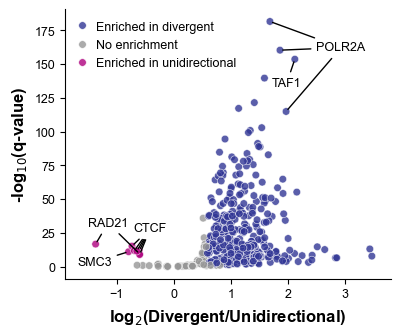

In [18]:
fig, ax = plt.subplots(figsize=(4.2,3.5))
plot_enrichment(df_enr[d], ax, [-1.9, 3.8])

# Add labels to highlight some proteins
for k in ns:
	if k in ["POLR2A", "TAF1"]:
		df_txt = df_enr[d][df_enr[d]["feature"]==k].sort_values(by=["log10.ttest.pval.adj", "log2fc.1vs2"], ascending=False)
	else:
		df_txt = df_enr[d][df_enr[d]["feature"]==k].sort_values(by=["log2fc.1vs2"])
	xs = df_txt["log2fc.1vs2"].head(ns[k])
	ys = df_txt["log10.ttest.pval.adj"].head(ns[k])
	
	for i, (x, y) in enumerate(zip(xs, ys)):
		xytext = {
			"POLR2A": (2.5, 160),
			"CTCF": (-0.7, 26),
			"RAD21": (-1.5, 30),
			"SMC3": (x-0.9, y-10),
		}.get(k, (x-0.4, y-20))
		color = "#FFFFFF" if k in ["POLR2A", "CTCF", "RAD21"] and i != ns[k]-1 else "#000000"
		ax.annotate(k, (x, y), xytext=xytext, arrowprops=dict(arrowstyle="-"), c=color, size=sfontsize)

plt.savefig(f"{PROJECT_DIR_o}figures/Fig1e.pdf", bbox_inches="tight", dpi=300) 

### Proximal

In [19]:
d = "proximal"
np.max(df_enr[d]["log2fc.1vs2"]), np.min(df_enr[d]["log2fc.1vs2"])

(4.660847819956131, -1.7255140251353918)

In [20]:
candidates = ["POLR2A", "TAF1", "RAD21", "SMC3", "CTCF", "SMAD5", "PHF8"]
ns2 = {}
for c in candidates:
	if c == "POLR2A":
		ns2[c] = 3
	else:
		ns2[c] = len(df_enr[d][df_enr[d]["feature"]==c])

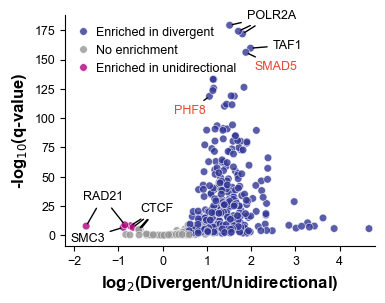

In [21]:
fig, ax = plt.subplots(figsize=(4,3))
plot_enrichment(df_enr[d], ax, [-2.2, 4.8])

# Add labels to highlight some proteins
for k in ns2:
	if k in ["POLR2A", "TAF1", "SMAD5", "PHF8"]:
		df_txt = df_enr[d][df_enr[d]["feature"]==k].sort_values(by=["log10.ttest.pval.adj", "log2fc.1vs2"], ascending=False)
	else:
		df_txt = df_enr[d][df_enr[d]["feature"]==k].sort_values(by=["log2fc.1vs2"])
	xs = df_txt["log2fc.1vs2"].head(ns2[k])
	ys = df_txt["log10.ttest.pval.adj"].head(ns2[k])

	for i, (x, y) in enumerate(zip(xs, ys)):
		xytext = {
			"POLR2A": (1.9, 185),
			"TAF1": (x+0.5, y),
			"PHF8": (x-0.8, y-15),
			"CTCF": (-0.5, 20),
			"RAD21": (-1.8, 30),
			"SMC3": (x-1.2, y-12),
		}.get(k, (x+0.2, y-15))
		
		if k in ["POLR2A", "CTCF", "RAD21"]:
			color = "#000000" if i == ns[k]-1 else "#FFFFFF"
		else:
			color = "#e34a33" if k in ["SMAD5", "PHF8"] else "#000000"
		ax.annotate(k, (x, y), xytext=xytext, arrowprops=dict(arrowstyle="-"), c=color, size=sfontsize)

plt.savefig(f"{PROJECT_DIR_o}supp_figures/SuppFig1d.pdf", bbox_inches="tight", dpi=300) 